<html>
<body>
<h1>Variational_Autoencoders_Conceptually_Explained</h1>
<h4> Author: Anshu Garg </h4>
<h4> Matriculation Number: 414686 </h4>
</body>
</html>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as ds
import torchvision.transforms as transform
from torch.autograd import Variable
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Running on GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Downloading Training and Test data

In [3]:
train_data = ds.MNIST(root = './data', train = True, transform = transform.Compose([transform.ToTensor(), transform.Normalize((0.5),(0.5))]), download= True)
test_data = ds.MNIST(root = './data', train=False, transform= transform.Compose([transform.ToTensor(), transform.Normalize((0.5),(0.5))]), download= True)

train_loader =  torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True, num_workers=4)

Defining the Convolutional Variational Autoencoder architecture

In [4]:
class CVAE(nn.Module):
  def __init__(self, o_c, k = 4, s = 2, p = 1, latent_dim = 32):
    super(CVAE, self).__init__()

    self.latent_dim = latent_dim

    self.layer_encoder = nn.Sequential(
        nn.Conv2d(in_channels=o_c[0],out_channels=o_c[1], kernel_size=k, stride=s, padding= p), #1, 64
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(o_c[1], o_c[2], k, s, p), # 64 ,128
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(o_c[2], o_c[3], 3, s, p), # 128, 256
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(o_c[3], o_c[5], k, 1, 0), # 256, 1024
        nn.LeakyReLU(0.2, inplace=True),
    )

    self.layer_decoder = nn.Sequential(
        nn.ConvTranspose2d(o_c[5], o_c[4], k, 1, 0),  #1024, 512
        nn.LeakyReLU(0.2, inplace=True),
        nn.ConvTranspose2d(o_c[4], o_c[3], 3, s, 1),  #512, 256
        nn.LeakyReLU(0.2, inplace=True),
        nn.ConvTranspose2d(o_c[3], o_c[2], k, s, p), #256, 128
        nn.LeakyReLU(0.2, inplace=True),
        nn.ConvTranspose2d(o_c[2], o_c[0], k, s, p), #128, 1
        nn.LeakyReLU(0.2, inplace=True),
    )

    self.fc1 = nn.Linear(o_c[5], o_c[4])  #1024, 512
    self.fc21 = nn.Linear(o_c[4], latent_dim) #512, latent_code
    self.fc22 = nn.Linear(o_c[4], latent_dim) #512, latent_code

    self.fc3 = nn.Linear(latent_dim, o_c[4])   #latent_code, 512
    self.fc4 = nn.Linear(o_c[4], o_c[5])  #512, 1024

  def encode(self, x):
      conv = self.layer_encoder(x)
      conv = conv.view(-1, o_c[5]) # 1, 1024
      hid1 = self.fc1(conv)
      return self.fc21(hid1), self.fc22(hid1)

  def decode(self, reparm_dim):
      hid3 = F.relu(self.fc3(reparm_dim))  #inp: reparm_dim, out: 512
      deconvolv_inp = self.fc4(hid3)   #inp: 512, out: 1024
      deconvolv_inp = deconvolv_inp.view(-1, o_c[5], 1, 1)  #1, 1024
      return self.layer_decoder(deconvolv_inp) 

  def reparametrisation(self, mu, logvar):
      st_deviation = logvar.mul(0.5).exp_()
      eps = torch.cuda.FloatTensor(st_deviation.size()).normal_()
      eps = Variable(eps)
      return (mu+st_deviation*eps)

  def forward(self, x):
      mu, logvar = self.encode(x)
      reparam = self.reparametrisation(mu, logvar)
      decoded_input = self.decode(reparam)
      return decoded_input, mu, logvar, reparam

Defining Hyper-parameters

In [5]:
o_c = [1, 64, 128, 256, 512, 1024]
kernel = 4
stride = 2
padding = 1
latent_sz = 64
l_rate = 0.01
epochs = 15

model = CVAE(o_c, kernel, stride, padding, latent_sz).to(device)
loss_criteria = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(), l_rate)

Training Model and printing Loss

In [6]:
loss_arr = []
for epoch in range(epochs):
  total_loss = 0
  for (inp, lbl) in train_loader:
    inp = inp.to(device)
    lbl = lbl.to(device)

    optimiser.zero_grad()
    decod_inp, mu, logvar, repar = model(inp)
    loss = loss_criteria(decod_inp, inp)
    loss.backward()
    optimiser.step()
    total_loss += loss.item()
  
  if epoch%3 == 0:
    loss_arr.append(total_loss/len(train_loader))
    print(loss_arr)

[0.3289400626808405]
[0.3289400626808405, 0.2694144021143516]
[0.3289400626808405, 0.2694144021143516, 0.21970831674287716]
[0.3289400626808405, 0.2694144021143516, 0.21970831674287716, 0.10050133413399259]
[0.3289400626808405, 0.2694144021143516, 0.21970831674287716, 0.10050133413399259, 0.06579493736674388]


Save trained model's weights

In [7]:
torch.save(model.state_dict(), './data2')
model.load_state_dict(torch.load('./data2'))

<All keys matched successfully>

Run model on test data and extract latent code of CVAE

In [8]:
cvae_latent_code = []
i = 0
for (inp,lbl) in test_loader:
  inp = inp.to(device)
  lbl = lbl.to(device)
  decod_inp, mu, logvar, repar = model(inp)
  cvae_latent_code.append(repar)

Visualise by using PCA and compare for different Latent dimensions

-------------------------Example:  1 ----------------------
-------------------------Latent dimention: 1 ----------------------


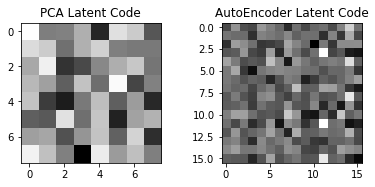

-------------------------Latent dimention: 2 ----------------------


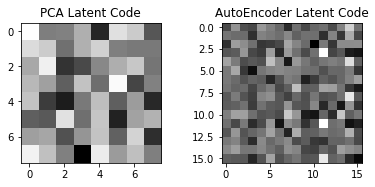

-------------------------Latent dimention: 3 ----------------------


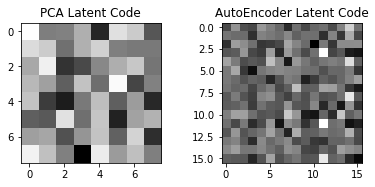

-------------------------Latent dimention: 4 ----------------------


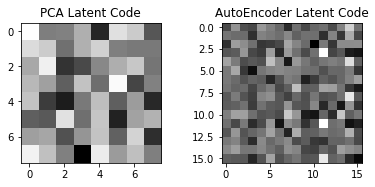

-------------------------Example:  2 ----------------------
-------------------------Latent dimention: 1 ----------------------


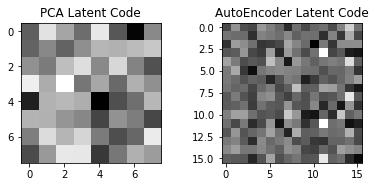

-------------------------Latent dimention: 2 ----------------------


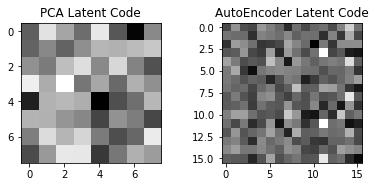

-------------------------Latent dimention: 3 ----------------------


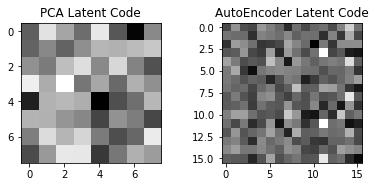

-------------------------Latent dimention: 4 ----------------------


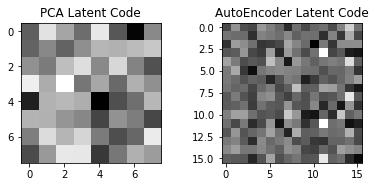

-------------------------Example:  3 ----------------------
-------------------------Latent dimention: 1 ----------------------


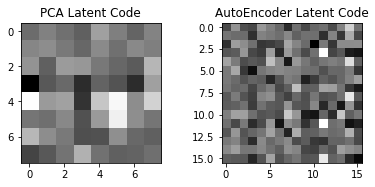

-------------------------Latent dimention: 2 ----------------------


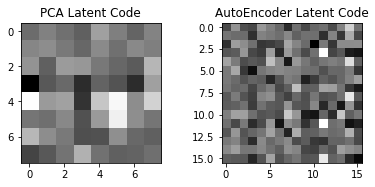

-------------------------Latent dimention: 3 ----------------------


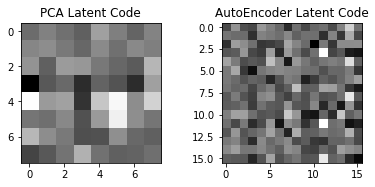

-------------------------Latent dimention: 4 ----------------------


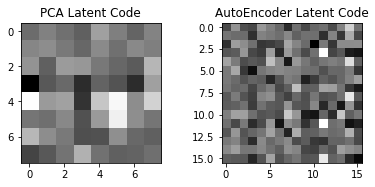

-------------------------Example:  4 ----------------------
-------------------------Latent dimention: 1 ----------------------


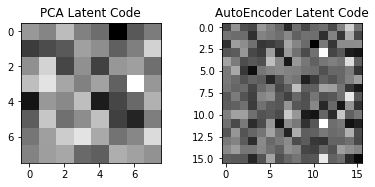

-------------------------Latent dimention: 2 ----------------------


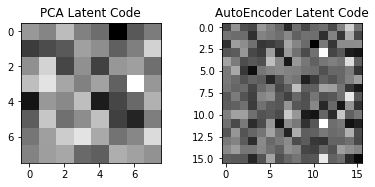

-------------------------Latent dimention: 3 ----------------------


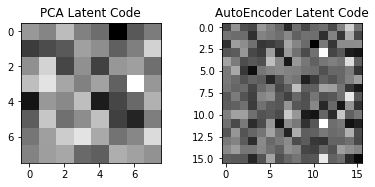

-------------------------Latent dimention: 4 ----------------------


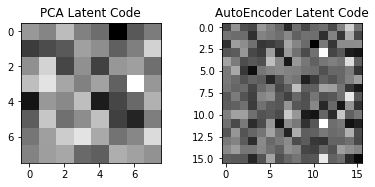

-------------------------Example:  5 ----------------------
-------------------------Latent dimention: 1 ----------------------


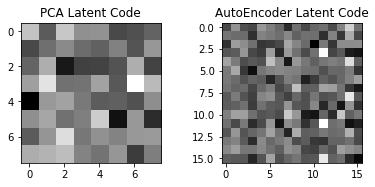

-------------------------Latent dimention: 2 ----------------------


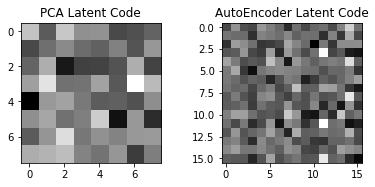

-------------------------Latent dimention: 3 ----------------------


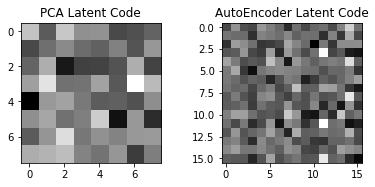

-------------------------Latent dimention: 4 ----------------------


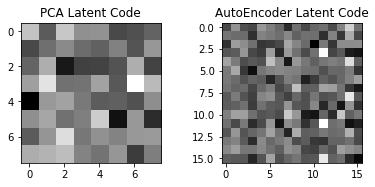

In [13]:
pca_component = [1,2,3,4]
for i in range(5):
  print("-------------------------Example: ",(i+1), "----------------------")
  for j in range(len(pca_component)):
    print("-------------------------Latent dimention:", pca_component[j],"----------------------")
    pca_ = PCA(n_components=pca_component[j])
    pca_.fit_transform(cvae_latent_code[i].cpu().detach().numpy())

    fig, axes =plt.subplots(1,2,gridspec_kw={'width_ratios':[8,8]})
    fig.tight_layout(pad = 3.0)
    axes[0].set_title("PCA Latent Code")
    axes[0].imshow(pca_.components_[0].reshape(8,8), cmap = 'gray')
    axes[1].set_title("AutoEncoder Latent Code")
    axes[1].imshow(cvae_latent_code[0].cpu().detach().numpy().reshape(16,16), cmap = 'gray')
    plt.show()

I have trained model now for 15 iterations because it was taking lot of time but if I increase the iteration it's loss will further reduce.